#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Загружаем необходимые библиоткеи.

In [1]:
!pip install pandas -q
!pip install phik -q
!pip install matplotlib -q
!pip install scikit-learn==1.0.2 -q

In [2]:
import pandas as pd
import warnings
warnings.simplefilter("ignore") 
import matplotlib.pyplot as plt
import phik
from phik.report import plot_correlation_matrix
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV, 
    RandomizedSearchCV,
    cross_val_score,
    TimeSeriesSplit
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import numpy as np
from scipy import stats as st
from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder,
    StandardScaler, 
    MinMaxScaler
)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.tree import DecisionTreeRegressor
from catboost import (
    CatBoostClassifier,
    CatBoostRegressor, 
    Pool
)
import lightgbm as lgb
from statsmodels.tsa.seasonal import seasonal_decompose

Вводим константы.

In [3]:
RANDOM_STATE = 42

Загружаем данные.

In [4]:
data = pd.read_csv('/datasets/taxi.csv', sep=',', index_col=[0], parse_dates=[0])
display(data.head(10))
data.info()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Ресемплируем данные по одному часу.

In [5]:
data.sort_index(inplace=True)
data = data.resample('1H').sum()
data.head(20)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


**Вывод по загрузке данных**

Датафрейм содержит информацию за период с **марта 2018 по август 2018**. Всего в датафрейме **26 496** записей, после ресемплирования заказов по часам **4416**.

## Анализ

Создадим графики декомпозиции.

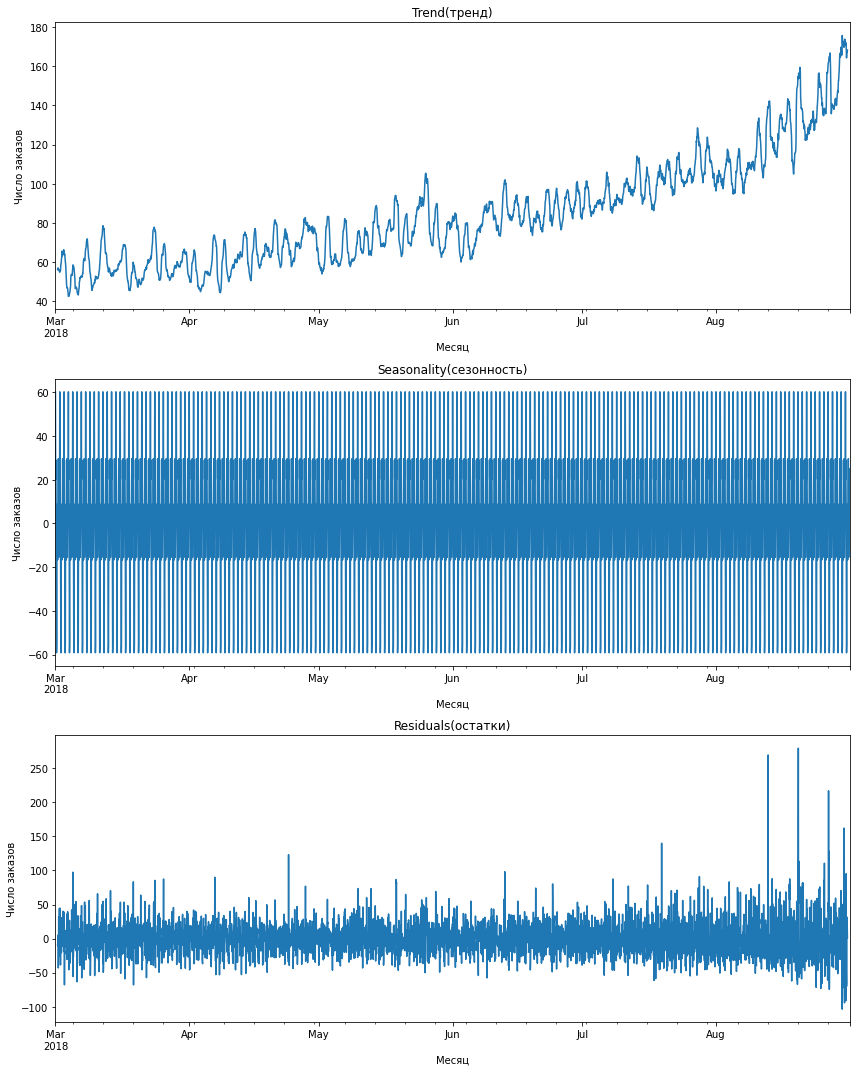

In [6]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(12, 15))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend(тренд)')
plt.ylabel('Число заказов')
plt.xlabel('Месяц')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality(сезонность)')
plt.xlabel('Месяц')
plt.ylabel('Число заказов')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals(остатки)')
plt.xlabel('Месяц')
plt.ylabel('Число заказов')
plt.tight_layout()
plt.show()

Мы получили тренд, сезонную составляющую и остаток декомпозиции. 
Тренд был положительный на протяжении всего рассматриваемого периода, и пик среднего значения заказов в день пришелся на конец августа. Остатки все время находились примерно в одном диапазоне.

Рассмотрим сезонность поближе, взяв период за двое суток.

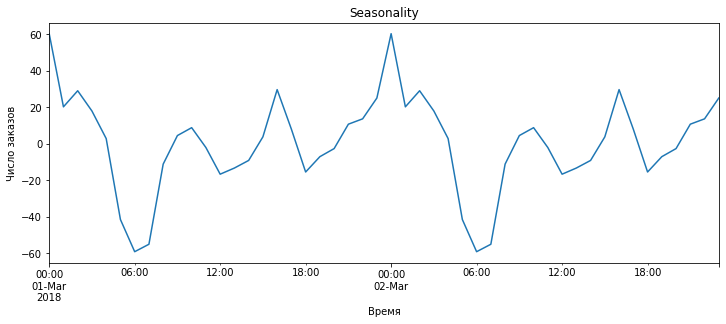

In [7]:
plt.figure(figsize=(12, 15))

plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-03-02'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.xlabel('Время')
plt.ylabel('Число заказов')
plt.show()

Больше всего заказов приходится на 12 ночи, а меньше всего на 6 утра.

Рассмотрим остатки.

In [8]:
data1 = data
data1['mean'] = data['num_orders'].shift().rolling(15).mean()
data1['std'] = data['num_orders'].shift().rolling(15).std()

data = data.drop(['mean','std'], axis=1)

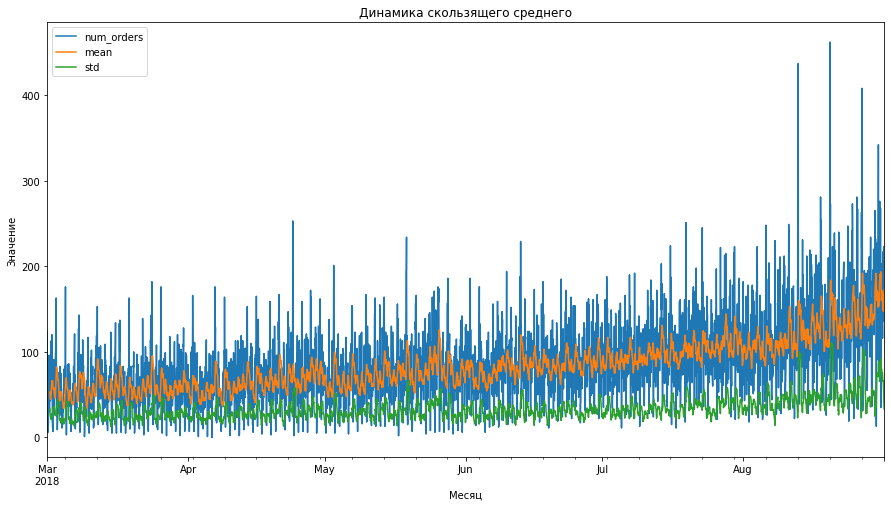

In [9]:
data1.plot(figsize=(15, 8)) 
plt.xlabel('Месяц')
plt.ylabel('Значение')
plt.title('Динамика скользящего среднего')
plt.show()

In [10]:
data2 = data.copy()
# Для скользящего среднего за 1 неделю - 7*24 - 168
data2['weekly_mean'] = data['num_orders'].shift().rolling(window=168).mean()
data2['weekly_std'] = data['num_orders'].shift().rolling(window=168).std()

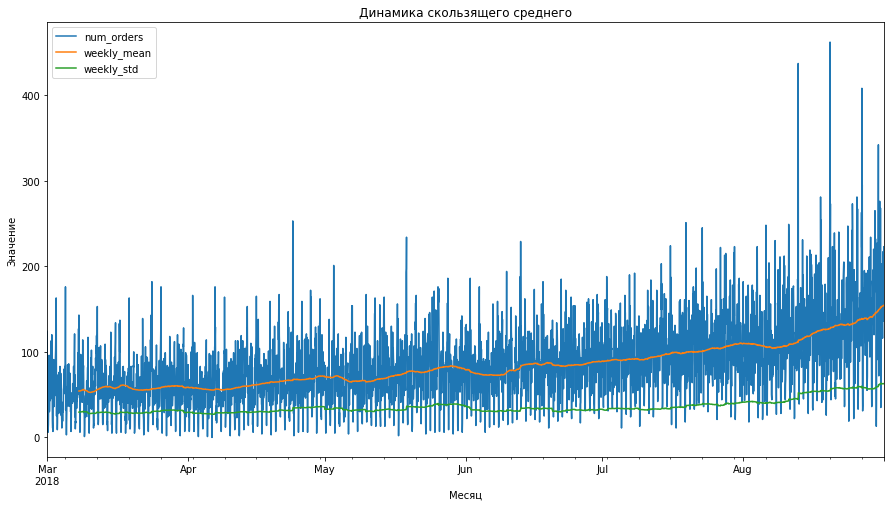

In [11]:
data2.plot(figsize=(15, 8)) 
plt.xlabel('Месяц')
plt.ylabel('Значение')
plt.title('Динамика скользящего среднего')
plt.show()

In [12]:
data3 = data.copy()
data3.sort_index(inplace=True)
data3 = data3.resample('D').sum()
data3.head()

,num_orders
datetime,
2018-03-01,1364
2018-03-02,1506
2018-03-03,1290
2018-03-04,1141
2018-03-05,1259


Text(0, 0.5, 'Число заказов')

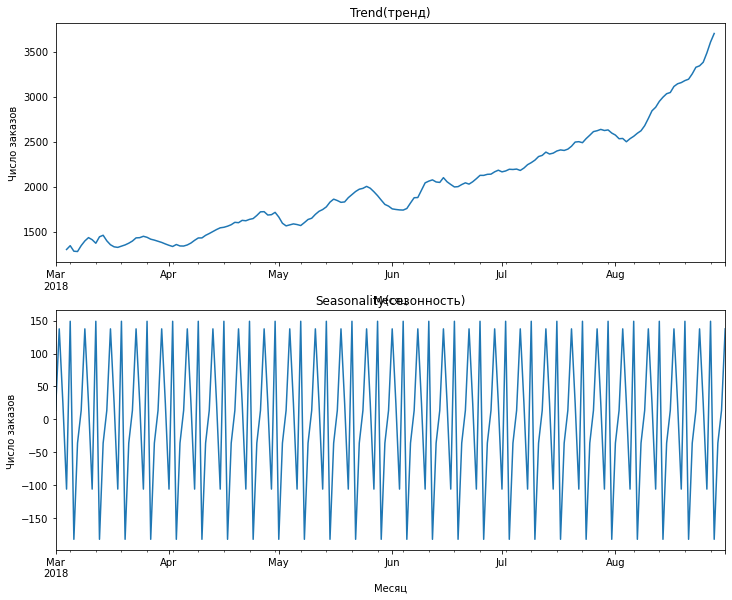

In [13]:
decomposed3 = seasonal_decompose(data3)

plt.figure(figsize=(12, 15))
plt.subplot(311)
decomposed3.trend.plot(ax=plt.gca())
plt.title('Trend(тренд)')
plt.ylabel('Число заказов')
plt.xlabel('Месяц')
plt.subplot(312)
decomposed3.seasonal.plot(ax=plt.gca())
plt.title('Seasonality(сезонность)')
plt.xlabel('Месяц')
plt.ylabel('Число заказов')

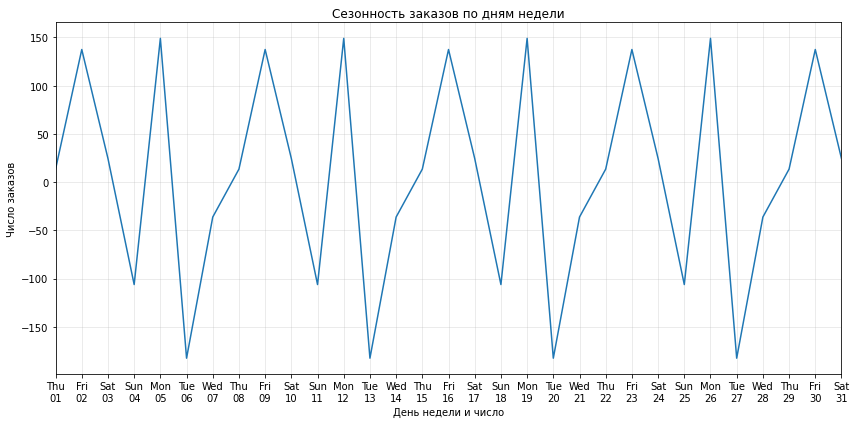

In [14]:
plt.figure(figsize=(12, 6))

# Берем данные за март 2018
march = decomposed3.seasonal['2018-03-01':'2018-03-31']

# Строим график
ax = march.plot()

# Настраиваем отображение дней недели
ax.set_xticks(march.index)
ax.set_xticklabels([d.strftime('%a\n%d') for d in march.index])

plt.title('Сезонность заказов по дням недели')
plt.xlabel('День недели и число')
plt.ylabel('Число заказов')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Видим восходящий тренд. Для сезонности заресемплили данные по суткам, декомпозировали. Взял весь март, чтобы увидеть общую картину по неделям. Действительно, пики приходятся на понедельники и пятницы, тогда как самое маленькое число заказов - на вторники и воскресенья. 

Среднее значение плавно возрастает с марта по август, а стандартное отклоение находится примерно в одном промежутке.

Создадим дополнительные признаки.

In [15]:
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(window = rolling_mean_size).mean() 
    return data

make_features(data,24,168)
data.head()

,num_orders,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


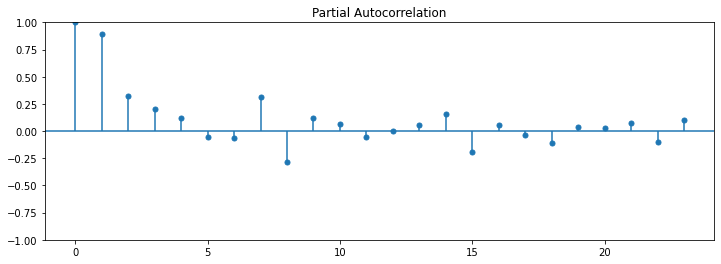

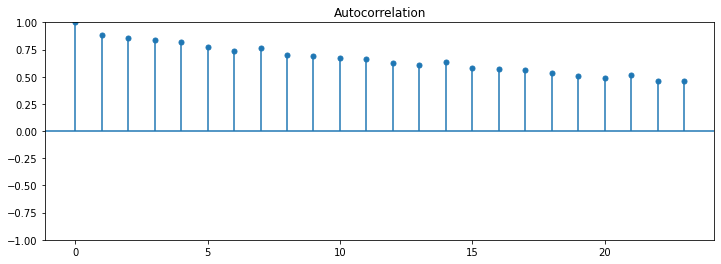

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_pacf(data3, alpha=None).set_size_inches(12, 4)
plt.show()

plot_acf(data3, alpha=None).set_size_inches(12, 4)
plt.show()

Создадим функцию которая выделит из даты в отдельные колонки месяц, день недели и час дня.

In [17]:
num_columns = data.select_dtypes(include=['float64','int64']).columns.tolist()
phik_matrix = data.phik_matrix(interval_cols=num_columns)

interval_cols = ['day', 'dayofweek', 'hour']
num_columns = [col for col in num_columns if col not in interval_cols]

Построим матрицу корреляции Phik.

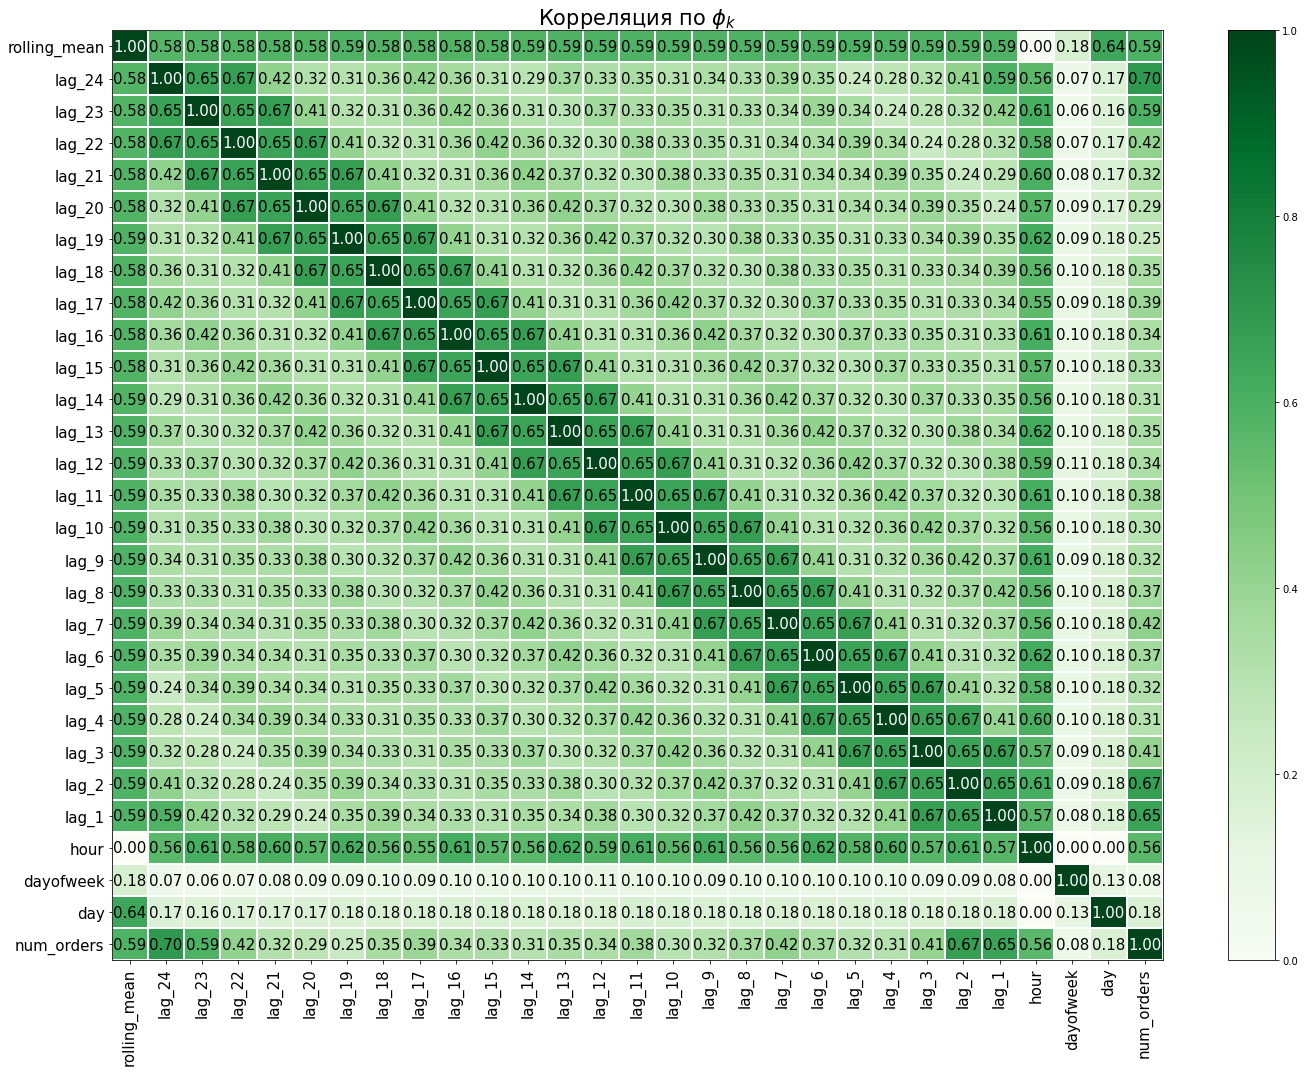

In [18]:
plot_correlation_matrix(phik_matrix.values, 
                       x_labels = phik_matrix.columns,
                       y_labels = phik_matrix.index,
                       vmin = 0, vmax = 1,color_map = 'Greens',
                       title = r'Корреляция по $\phi_k$',
                       fontsize_factor = 1.5, 
                       figsize = (20,15)
                       )

Больше всего на целевую переменную влияют показатели лагов за 24, 2 и 1 итерации.

**Вывод по предобработке и анализу данных**

* В данных нет пропусков, дупликатов.
* Был произведен ресемплинг за 1 час.
* Созданы признаки с месяцем, днем, днем недели, часом, отстающие значения, скользящее среднее.
* Пик среднего значения заказов в день приходится на конец августа.
* Больше всего заказов приходится на 12 ночи, а меньше всего на 6 утра.
* Пики заказов по дням недели приходятся на понедельники и пятницы, тогда как самое маленькое число заказов - на вторники и воскресенья. 
* Среднее значение плавно возрастает с марта по август, а стандартное отклоение находится примерно в одном промежутке.
* Больше всего на целевую переменную влияют показатели лагов за 24, 2 и 1 итерации.

## Обучение

Создадим тренировочную и тестовую выборку размером 10% от всей выборки и укажем параметр, чтобы значения не перемешивались. Сразу удалим строчки с пропущенными значениями, так как они будут сбивать модель.

In [19]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

Выведем минимумы и максимумы получившихся выборок.

In [20]:
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-08 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


Выделим целевой признак.

In [21]:
X_train = train.drop(
        ['num_orders'
        ], 
        axis=1
    )
y_train = train['num_orders']

X_test = test.drop(
        ['num_orders'
        ], 
        axis=1
    )
y_test = test['num_orders']

Создадим пайплайн.

In [22]:
ohe_pipe = Pipeline([
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (    'ohe', 
            OneHotEncoder(sparse=False, handle_unknown='ignore',drop='first')
        )
])

Соберем все численные переменные в датафрейме с помощью функции и сохраним их в переменную.

In [23]:
cat_columns = X_train.select_dtypes(include=['int64']).columns.tolist()
cat_columns = [col for col in cat_columns if col not in num_columns]

target = 'num_orders'
num_columns = [col for col in num_columns if col not in target]

Создаем пайплайн для подготовки данных.

In [24]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, cat_columns),
        ('num', MinMaxScaler(), num_columns)   
    ], 
    remainder =  'passthrough'
)
print(data_preprocessor)

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 Pipeline(steps=[('simpleImputer_ohe',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['day', 'dayofweek', 'hour']),
                                ('num', MinMaxScaler(),
                                 ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5',
                                  'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10',
                                  'lag_11', 'lag_12', 'lag_13', 'lag_14',
                                  'lag_15', 'lag_16', 'lag_17', 'lag_18',
                     

Создаём итоговый пайплайн: подготовка данных и модель

In [25]:
pipe_final= Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)

In [26]:
param_distributions = [
    {
    # словарь для модели DecisionTreeRegressor()
    'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
    'models__max_depth': range(1,6),
    'models__min_samples_split': range(2,8),
    'models__min_samples_leaf': range(2, 8),
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

Определим метрику RMSE.

In [27]:
rmse_scorer = make_scorer(mean_squared_error, squared=False)

Используем TimeSeriesSplit для кросс-валидации.

In [28]:
tscv = TimeSeriesSplit(n_splits=5)

In [29]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions, 
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=-1
)

In [30]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                   

In [31]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['day', 'dayofweek', 'hour']),
                                                 ('num', 'passthrough',
                                                  ['lag_1', 'lag_2', 'lag_3',
                

In [32]:
print ('Метрика лучшей модели на тренировочной выборке:', -randomized_search.best_score_)

Метрика лучшей модели на тренировочной выборке: 29.952298198596832


Создадим модель LightGMB и подберем гипермараметры для нее в пайплайне.

In [33]:
# Создание трансформера для предобработки данных
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                handle_unknown='use_encoded_value',
                unknown_value=-1
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('ord', ord_pipe, cat_columns),
        ('num', StandardScaler(), num_columns)
    ])

# Создание модели
model = lgb.LGBMRegressor(random_state=RANDOM_STATE, objective='regression', metric='rmse', verbosity=-1)

# Создание пайплайна
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# Параметры для RandomizedSearchCV
param_distributions = {
    'classifier__n_estimators': range(50, 200),
    'classifier__num_leaves': range(3, 10),
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'classifier__n_estimators' : range(60,80),
    'classifier__max_depth': range(1,10)
}


# Создание RandomizedSearchCV
grid_search = RandomizedSearchCV(
    pipe,
    param_distributions,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_iter=10,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [34]:
grid_search.fit(X_train, y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('ord',
                                                                               Pipeline(steps=[('simpleImputer_before_ord',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ord',
                                                                                                OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                               unknown_value=-1)),
                                                                                               ('simpleImputer_a..

In [35]:
print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', -grid_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1)),
                                                                  ('simpleImputer_after_ord',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['day', 'dayofweek', 'hour']),
                                                 ('num', StandardScale...
                    

### Вывод по обучению моделей

Выведем более подробные результаты об их работе.

In [36]:
best_model1 = randomized_search.best_estimator_.named_steps['models']
best_model2 = grid_search.best_estimator_.named_steps['classifier']


#scores = [roc_auc_cv,cv_resultsTRUE,rmse_cv]
name_of_best_models = [best_model1,best_model2]
models = [randomized_search, grid_search ]

fit_times = []
score_times = []
rmse_scores = []

# Обучение моделей и извлечение времени выполнения
for model in models:
    cv_results1 = pd.DataFrame(model.cv_results_)
    best_index = cv_results1['mean_test_score'].idxmin()
    fit_times.append(cv_results1.loc[best_index, 'mean_fit_time'])
    score_times.append(cv_results1.loc[best_index, 'mean_score_time'])
    rmse_scores.append(-model.best_score_)

# Печать результатов
for i, (fit_time, score_time,rmse_scores) in enumerate(zip(fit_times, score_times,rmse_scores), start=1):
    print(f"Показатели модели {name_of_best_models[i-1]}")
    print(f"Время обучения лучшей модели: {fit_time} секунд")
    print(f"Время предсказания лучшей модели : {score_time} секунд")
    print(f"Значение метрики RMSE на тренировочной выборке модели  : {rmse_scores}")
    print()

Показатели модели DecisionTreeRegressor(max_depth=5, min_samples_leaf=6, min_samples_split=7,
                      random_state=42)
Время обучения лучшей модели: 0.014927482604980469 секунд
Время предсказания лучшей модели : 0.006044197082519531 секунд
Значение метрики RMSE на тренировочной выборке модели  : 29.952298198596832

Показатели модели LGBMRegressor(max_depth=9, metric='rmse', n_estimators=78, num_leaves=9,
              objective='regression', random_state=42, verbosity=-1)
Время обучения лучшей модели: 0.15354418754577637 секунд
Время предсказания лучшей модели : 0.023152732849121095 секунд
Значение метрики RMSE на тренировочной выборке модели  : 25.18331870886927



**Итог**
Метрика RMSE лучше у модели LightGBM - **25.18**, но она дольше обучается. Так как нам важнее значение метрик, то выберем модель **LightGBM**.

## Тестирование

Делаем предсказание на тестовой выборке.

In [37]:
y_pred = grid_search.predict(X_test)

Вычисляем метрики RMSE на тестовой выборке.

In [38]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Значение метрики RMSE на тестовой выборке : {rmse}")

Значение метрики RMSE на тестовой выборке : 42.1738376745172


Значение метрики RMSE у модели **LGBMRegressor(max_depth=9, metric='rmse', n_estimators=78, num_leaves=9,objective='regression', random_state=42, verbosity=-1)** равняется **42.17**. Это значение удовлетворяет условие - меньше 48.

## Общие выводы

**Загрузка данных**

Датафрейм содержит информацию за период с **марта 2018 по август 2018**. Всего в датафрейме **26 496** записей, после ресемплирования заказов по часам **4416**.

**Предобработка и анализ данных**

* В данных нет пропусков, дупликатов.
* Был произведен ресемплинг за 1 час.
* Созданы признаки с месяцем, днем, днем недели, часом, отстающие значения, скользящее среднее.
* Пик среднего значения заказов в день приходится на конец августа.
* Больше всего заказов приходится на 12 ночи, а меньше всего на 6 утра.
* Среднее значение плавно возрастает с марта по август, а стандартное отклоение находится примерно в одном промежутке.
* Больше всего на целевую переменную влияют показатели лагов за 24, 2 и 1 итерации.

**Обучение моделей**

Метрика RMSE лучше у модели LightGBM - **25.18**, но она дольше обучается. Так как нам важнее значение метрик, то выберем модель **LightGBM**.

**Предсказание тестовой выборки**

Значение метрики RMSE у модели **LGBMRegressor(max_depth=9, metric='rmse', n_estimators=78, num_leaves=9,objective='regression', random_state=42, verbosity=-1)** равняется **42.17**. Это значение удовлетворяет условие - меньше 48.